<a href="https://colab.research.google.com/github/nicrtellez/sentiment-analysis-craft-retrieval-program/blob/main/Analysis_of_UFO_Subreddit_WSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries
import pandas as pd
import datetime

In [2]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.3 MB/s eta 0:00:00


# Select DATA
Set up dataset

In [3]:
# set up Reddit API credentials
import praw
import pprint

SECRET = "duSOBXWf5I-p5faKAgNsc7JLiaQKRg"
APP_ID = "cdg8H_ra-Tjn6N4aW8mATQ"

reddit = praw.Reddit(
    client_id = APP_ID,
    client_secret = SECRET,
    user_agent = "Comment Extraction"
)

In [4]:
#select subreddit and post
url = 'https://www.reddit.com/r/UFOs/comments/141ch26/intelligence_officials_say_us_has_retrieved_craft/'
post = reddit.submission(url=url)

# 1.2 Data Collection

In [5]:
# create dictionary to store post comments
rows = []

for n, comment in enumerate(post.comments.list()):
    if n == 200: # limit to 200 comments
        break
    if not comment.author: #passes the function through even if the author is not present
        continue
    row = { "author": comment.author.name,
           "comment": comment.body,
           "created_utc": comment.created_utc,
           "num of words": len(comment.body.split()),
           "score": comment.score,}
    rows.append(row)

# convert to pandas dataframe
df = pd.DataFrame(rows)
df.head()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,author,comment,created_utc,num of words,score
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,1.685983e+09,171,1
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,1.685978e+09,15,1081
2,frank11979,I read this article and watched the 1 hour You...,1.685984e+09,111,338
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,1.685988e+09,231,1951
4,-Hikifroggy-,Please for the love of God. Let this be the st...,1.685976e+09,18,1626


In [6]:
# import libraries to adjust the date format
from datetime import datetime
from datetime import timezone

In [7]:
# convert created_utc to datetime and format it
df['created_utc'] = df['created_utc'].apply(
    lambda x: datetime.fromtimestamp(x).replace(tzinfo=timezone.utc).strftime("%m/%d/%Y %I:%M:%S %p %Z")
)
df.head()

,author,comment,created_utc,num of words,score
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,06/05/2023 04:40:54 PM UTC,171,1
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,06/05/2023 03:07:35 PM UTC,15,1081
2,frank11979,I read this article and watched the 1 hour You...,06/05/2023 04:47:33 PM UTC,111,338
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,06/05/2023 06:02:12 PM UTC,231,1951
4,-Hikifroggy-,Please for the love of God. Let this be the st...,06/05/2023 02:38:38 PM UTC,18,1626


# 1.3 Data Preprocessing
Set up preprocessing pipeline

In [8]:
# 1. common case
def lower_case(text):
    return text.lower()

In [9]:
# 2. stripping whitespace
def leading_whitespace(text):
    return text.strip()

In [10]:
# 3. text substitution
import re
def replace_markets(text):
    pattern = r"\$\d+"
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
    # text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'\-', '', text) # remove dashes
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove special characters
    return text

In [11]:
# 4. hyperlink replacement
def replace_hyperlinks(text):
    pattern = r"(https://|http://)[A-Za-z0-9\/\.]+"
    text = re.sub(pattern, '{link}', text) # remove hyperlinks and replace
    return text

In [12]:
# apply preprocessing pipeline to the 'comment' column

def preprocessing_pipeline(text):
    text = lower_case(text)
    text = leading_whitespace(text)
    text = replace_markets(text)
    text = replace_hyperlinks(text)
    return text

# apply the preprocessing pipeline to the newly created 'cleaned_comment' column
df['preprocessed text'] = df['comment'].apply(preprocessing_pipeline)
df.head()

,author,comment,created_utc,num of words,score,preprocessed text
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,06/05/2023 04:40:54 PM UTC,171,1,post stickied\n\nthis is an ongoing story with...
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,06/05/2023 03:07:35 PM UTC,15,1081,\n\na david grusch a ufg intelligence duty of...
2,frank11979,I read this article and watched the 1 hour You...,06/05/2023 04:47:33 PM UTC,111,338,i read this article and watched the 1 hour you...
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,06/05/2023 06:02:12 PM UTC,231,1951,reposting my eli5 for others\n\nmy eli5 a high...
4,-Hikifroggy-,Please for the love of God. Let this be the st...,06/05/2023 02:38:38 PM UTC,18,1626,please for the love of god let this be the sto...


In [13]:
df.to_csv('/content/preprocessed_text.csv', index=False)

# 1.4 Stopword Removal

In [14]:
!pip install nltk

In [15]:
# import libraries to remove stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# remove stopwords
from nltk.corpus import stopwords

additional_stopwords = ['u', 'i', 'im', 'us', 'we', 'our', 'you', 'your', 'they', 'their', 'he', 'she', 'it', 'its', 'like']

def preprocess(row):
  text = row["preprocessed text"] # apply the preprocessing pipeline to the 'preprocessed text' column
  keep = []
  stop_words = set(stopwords.words("english") + additional_stopwords)  # Get the stopwords set and add additional stopwords
  for word in text.split():
    if word not in stop_words:  # Check against the stopwords set
      keep.append(word)
  return ' '.join(keep)

# create a new column 'cleaned_comment'
df["cleaned_comment"] = df.apply(preprocess, axis=1)
df.head()

,author,comment,created_utc,num of words,score,preprocessed text,cleaned_comment
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,06/05/2023 04:40:54 PM UTC,171,1,post stickied\n\nthis is an ongoing story with...,post stickied ongoing story information come n...
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,06/05/2023 03:07:35 PM UTC,15,1081,\n\na david grusch a ufg intelligence duty of...,david grusch ufg intelligence duty officer men...
2,frank11979,I read this article and watched the 1 hour You...,06/05/2023 04:47:33 PM UTC,111,338,i read this article and watched the 1 hour you...,read article watched 1 hour youtube video than...
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,06/05/2023 06:02:12 PM UTC,231,1951,reposting my eli5 for others\n\nmy eli5 a high...,reposting eli5 others eli5 high level military...
4,-Hikifroggy-,Please for the love of God. Let this be the st...,06/05/2023 02:38:38 PM UTC,18,1626,please for the love of god let this be the sto...,please love god let story finally cracks egg w...


# 1.5 Filtering for impactful comments

In [17]:
# filter out comments with less than 5 words
df_filtered = df[df['num of words'] > 5]
df_filtered

,author,comment,created_utc,num of words,score,preprocessed text,cleaned_comment
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,06/05/2023 04:40:54 PM UTC,171,1,post stickied\n\nthis is an ongoing story with...,post stickied ongoing story information come n...
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,06/05/2023 03:07:35 PM UTC,15,1081,\n\na david grusch a ufg intelligence duty of...,david grusch ufg intelligence duty officer men...
2,frank11979,I read this article and watched the 1 hour You...,06/05/2023 04:47:33 PM UTC,111,338,i read this article and watched the 1 hour you...,read article watched 1 hour youtube video than...
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,06/05/2023 06:02:12 PM UTC,231,1951,reposting my eli5 for others\n\nmy eli5 a high...,reposting eli5 others eli5 high level military...
4,-Hikifroggy-,Please for the love of God. Let this be the st...,06/05/2023 02:38:38 PM UTC,18,1626,please for the love of god let this be the sto...,please love god let story finally cracks egg w...
...,...,...,...,...,...,...,...
162,Nekryyd,Bruh... This guy was a point man in the UAP Ta...,06/05/2023 07:30:36 PM UTC,80,6,bruh this guy was a point man in the uap task ...,bruh guy point man uap task force xcom lets go...
163,Wewoo3,Now this is the type of once in a lifetime mil...,06/05/2023 07:56:21 PM UTC,19,5,now this is the type of once in a lifetime mil...,type lifetime milestones millennial want hear
164,Avoxxis,"Please let it be aliens, please let it be aliens…",06/05/2023 08:35:46 PM UTC,10,7,please let it be aliens please let it be aliens,please let aliens please let aliens
165,Nosferatu1983,Historically (and of course allegedly) aliens ...,06/05/2023 09:17:30 PM UTC,80,5,historically and of course allegedly aliens ha...,historically course allegedly aliens made appe...


In [18]:
# show raw comments and post cleaning process
df_filtered[['comment', 'cleaned_comment']].head(10)

,comment,cleaned_comment
0,Post stickied.\n\n**This is an ongoing story w...,post stickied ongoing story information come n...
1,https://www.af.mil/News/Article-Display/Articl...,david grusch ufg intelligence duty officer men...
2,I read this article and watched the 1 hour You...,read article watched 1 hour youtube video than...
3,Reposting my ELI5 for others:\n\n**My ELI5:** ...,reposting eli5 others eli5 high level military...
4,Please for the love of God. Let this be the st...,please love god let story finally cracks egg w...
5,If anyone is wondering why this is such a big ...,anyone wondering big deal beginning 2022 grusc...
6,For someone being off and on deeply into the t...,someone deeply topic 35 years sure exciting th...
7,">Grusch left the government on April 7, 2023, ...",grusch left government april 7 2023 order said...
8,Grusch said the recoveries of partial fragment...,grusch said recoveries partial fragments intac...
9,"Everyone who cares about this, write, publiciz...",everyone cares write publicize give oxygen nee...


# 2. Exploratory Analysis

# 2.1 Analysis of Popular Words

In [19]:
# create a frequency table of the most common words
from collections import Counter
import matplotlib.pyplot as plt

word_counter = Counter()
for row in df_filtered.to_dict("records"):
  word_counter.update(row['cleaned_comment'].split())
df_term_frequency = pd.DataFrame(word_counter.most_common(50))
df_term_frequency.columns = ["term", "frequency"]
df_term_frequency.head(5)

,term,frequency
0,intelligence,37
1,story,26
2,article,26
3,grusch,25
4,information,23


In [20]:
df_term_frequency_top15 = df_term_frequency.head(15)

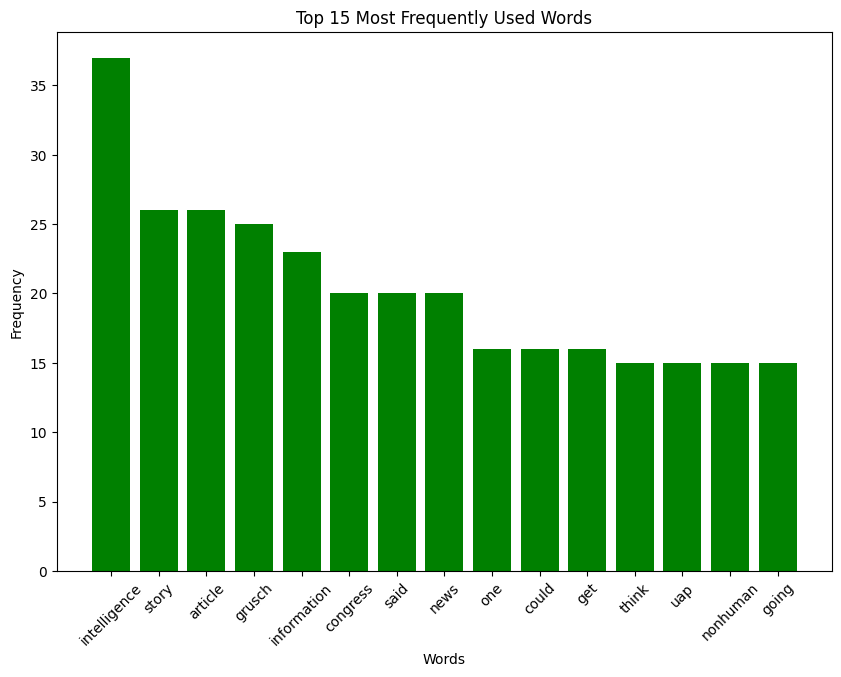

In [21]:
# bar chart for popular word frequency

plt.figure(figsize=(10,7))
plt.bar(df_term_frequency_top15['term'], df_term_frequency_top15['frequency'], color = 'g')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Frequently Used Words')
plt.savefig('/content/freq_bar_chart.png')
plt.show()

# 2.2 Word Cloud

In [22]:
# import libraries in order to create a bar chart for frequency and word cloud
!pip install wordcloud
from wordcloud import WordCloud

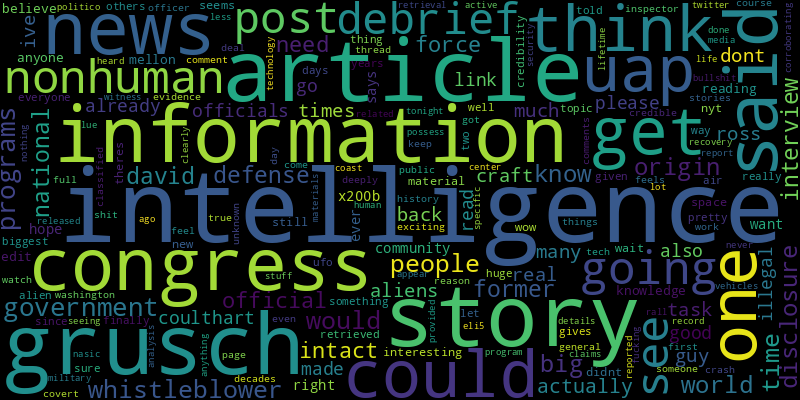

In [23]:
# create a word cloud
cloud = WordCloud(width=800, height=400,)
cloud.generate_from_frequencies(dict(word_counter.most_common(200)))
ufo_word_cloud = cloud.to_image()
ufo_word_cloud

In [24]:
ufo_word_cloud.save("/content/ufo_wordcloud.png")

# 2.3 Time Series analysis of comments

In [25]:
# create copy to maintain integrity of cleaned data set
df_time_series = df.copy()

In [26]:
# convert time to more readable format
df_time_series['created_utc'] = pd.to_datetime(df_time_series['created_utc'])
df_time_series['created_day_hour'] = df_time_series['created_utc'].dt.strftime('%m/%d/%Y %H %Z')
df_time_series.head()

<ipython-input-26-6c3601713ac7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time_series['created_utc'] = pd.to_datetime(df_time_series['created_utc'])


,author,comment,created_utc,num of words,score,preprocessed text,cleaned_comment,created_day_hour
0,ZolotoG0ld,Post stickied.\n\n**This is an ongoing story w...,2023-06-05 16:40:54+00:00,171,1,post stickied\n\nthis is an ongoing story with...,post stickied ongoing story information come n...,06/05/2023 16 UTC
1,no13wirefan,https://www.af.mil/News/Article-Display/Articl...,2023-06-05 15:07:35+00:00,15,1081,\n\na david grusch a ufg intelligence duty of...,david grusch ufg intelligence duty officer men...,06/05/2023 15 UTC
2,frank11979,I read this article and watched the 1 hour You...,2023-06-05 16:47:33+00:00,111,338,i read this article and watched the 1 hour you...,read article watched 1 hour youtube video than...,06/05/2023 16 UTC
3,KatetCadet,Reposting my ELI5 for others:\n\n**My ELI5:** ...,2023-06-05 18:02:12+00:00,231,1951,reposting my eli5 for others\n\nmy eli5 a high...,reposting eli5 others eli5 high level military...,06/05/2023 18 UTC
4,-Hikifroggy-,Please for the love of God. Let this be the st...,2023-06-05 14:38:38+00:00,18,1626,please for the love of god let this be the sto...,please love god let story finally cracks egg w...,06/05/2023 14 UTC


In [27]:
# group by date and count the number of comments
df_time_series = df_time_series.groupby(['created_day_hour']).size()
df_time_series = df_time_series.reset_index(name='counts')
df_time_series.head()

,created_day_hour,counts
0,06/05/2023 12 UTC,14
1,06/05/2023 13 UTC,20
2,06/05/2023 14 UTC,22
3,06/05/2023 15 UTC,15
4,06/05/2023 16 UTC,19


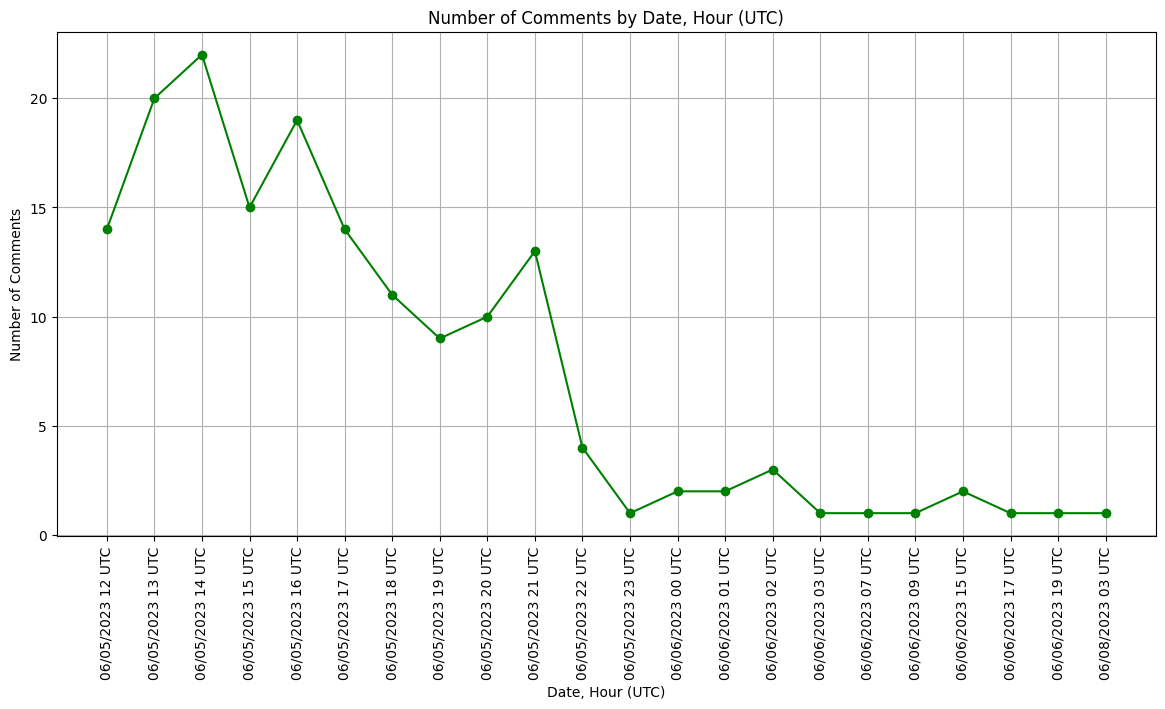

In [28]:
#plot the number of comments by date
plt.figure(figsize=(12, 6))
plt.plot(df_time_series['created_day_hour'], df_time_series['counts'], marker='o', linestyle='-', color = 'g')
plt.title('Number of Comments by Date, Hour (UTC)')
plt.ylabel('Number of Comments')
plt.xlabel('Date, Hour (UTC)')
plt.grid()
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('/content/time_series_chart.png')
plt.show()

# Text mining

# 3.1 - Sentiments Analysis

In [29]:
# Modeling sentiments and opinions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [30]:
# initialize the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# create a copy of dataframe to apply VADER tool
columns = ['comment', 'preprocessed text', 'score']
df_sentiment = df[columns]

# use lambda to apply VADER score to preprocessed text
df_sentiment['sentiment'] = df_sentiment['preprocessed text'].apply(lambda x: vader.polarity_scores(x)['compound'])
df_sentiment.head()

<ipython-input-30-50a4b4392104>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['sentiment'] = df_sentiment['preprocessed text'].apply(lambda x: vader.polarity_scores(x)['compound'])


,comment,preprocessed text,score,sentiment
0,Post stickied.\n\n**This is an ongoing story w...,post stickied\n\nthis is an ongoing story with...,1,0.6908
1,https://www.af.mil/News/Article-Display/Articl...,\n\na david grusch a ufg intelligence duty of...,1081,0.4767
2,I read this article and watched the 1 hour You...,i read this article and watched the 1 hour you...,338,0.7717
3,Reposting my ELI5 for others:\n\n**My ELI5:** ...,reposting my eli5 for others\n\nmy eli5 a high...,1951,0.8765
4,Please for the love of God. Let this be the st...,please for the love of god let this be the sto...,1626,0.8225


In [31]:
# understand the statistics surrounding the sentiment scores
df_sentiment['sentiment'].describe()

,sentiment
count,167.000000
mean,0.226605
std,0.443249
min,-0.947500
25%,0.000000
50%,0.077200
75%,0.624650
max,0.991200


In [32]:
# understand the sentiment scores
df_sentiment['score'].describe()

,score
count,167.000000
mean,131.083832
std,302.893067
min,1.000000
25%,11.500000
50%,24.000000
75%,97.500000
max,2112.000000


In [33]:
# categorize VADER scores as 'positive', 'negative', and 'neutral'

def sentiment_category(row):
    if row['sentiment'] > 0.05:
        return 'positive'
    elif row['sentiment'] < -0.05:
        return 'negative'
    else:
        return 'neutral'
df_sentiment['sentiment_classification'] = df_sentiment.apply(sentiment_category, axis=1)
df_sentiment.head()

<ipython-input-33-eebd7a8fe30d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['sentiment_classification'] = df_sentiment.apply(sentiment_category, axis=1)


,comment,preprocessed text,score,sentiment,sentiment_classification
0,Post stickied.\n\n**This is an ongoing story w...,post stickied\n\nthis is an ongoing story with...,1,0.6908,positive
1,https://www.af.mil/News/Article-Display/Articl...,\n\na david grusch a ufg intelligence duty of...,1081,0.4767,positive
2,I read this article and watched the 1 hour You...,i read this article and watched the 1 hour you...,338,0.7717,positive
3,Reposting my ELI5 for others:\n\n**My ELI5:** ...,reposting my eli5 for others\n\nmy eli5 a high...,1951,0.8765,positive
4,Please for the love of God. Let this be the st...,please for the love of god let this be the sto...,1626,0.8225,positive


<Axes: ylabel='Frequency'>

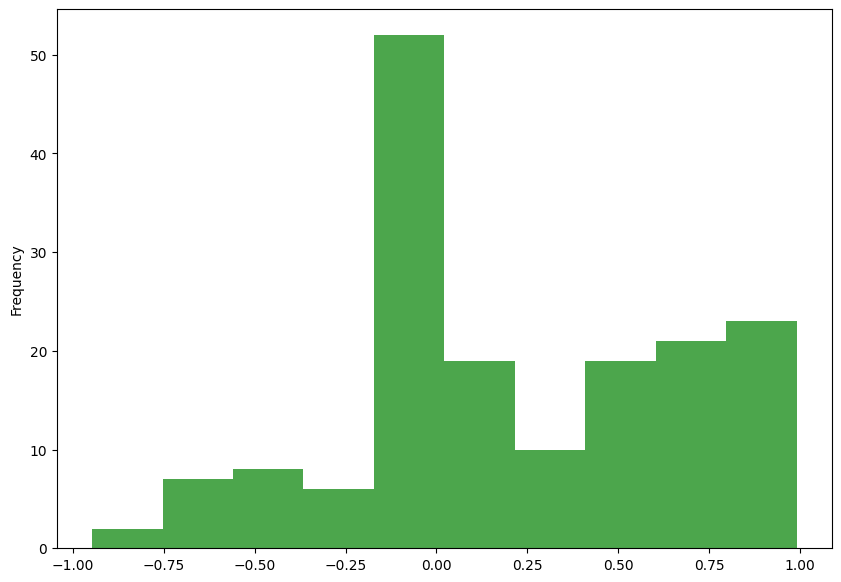

In [34]:
# plot the sentiment distribution
df_sentiment['sentiment'].plot(kind='hist', figsize=(10, 7), color = 'g', alpha=0.7)

<Axes: ylabel='Frequency'>

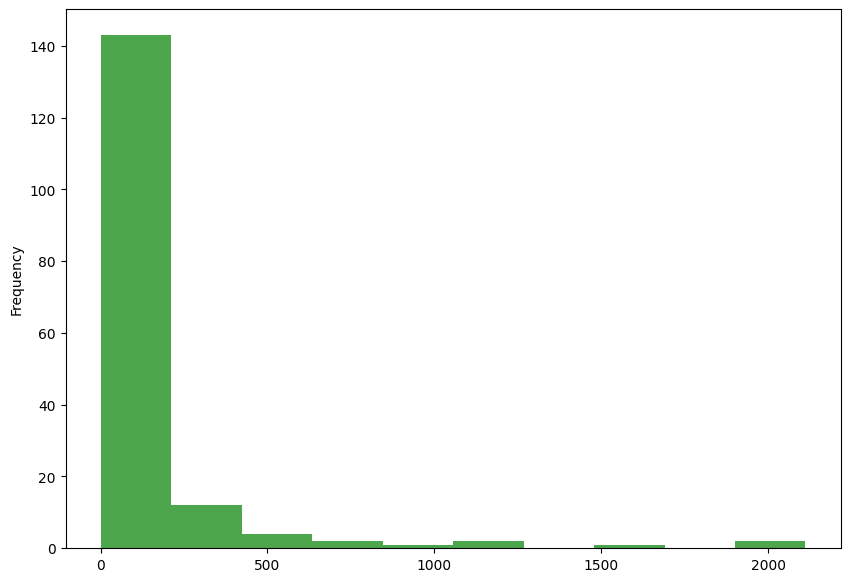

In [35]:
# plot the score distribution of sentiment scores
df_sentiment['score'].plot(kind='hist', figsize=(10, 7), color = 'g', alpha=0.7)

In [36]:
# sort comment by sentiment and display the top 10 most positive comments
df_sentiment.sort_values(by='sentiment', ascending=False).head(10)[['comment', 'sentiment', 'score']]

,comment,sentiment,score
6,For someone being off and on deeply into the t...,0.9912,2112
7,">Grusch left the government on April 7, 2023, ...",0.9790,645
117,I see a similar skeptical sentiment throughout...,0.9738,9
68,>Jonathan Grey is a generational officer of th...,0.9657,20
77,I feel so full right now. I have been interest...,0.9444,16
30,Why now? I sure hope there not a big surprise ...,0.9393,281
54,"Lue Elizondo: ""To Dave, my friend and former c...",0.9022,88
112,\n\n\nThe following submission statement was p...,0.8779,59
41,A 60 Minutes producer has retweeted this story...,0.8772,338
3,Reposting my ELI5 for others:\n\n**My ELI5:** ...,0.8765,1951


In [37]:
# sort comment by score and display the top 10 highest scored comments
df_sentiment.sort_values(by='score', ascending=False).head(10)[['comment', 'sentiment', 'score']]

,comment,sentiment,score
6,For someone being off and on deeply into the t...,0.9912,2112
3,Reposting my ELI5 for others:\n\n**My ELI5:** ...,0.8765,1951
4,Please for the love of God. Let this be the st...,0.8225,1626
10,https://youtu.be/rQjbFZT9_EM\n\nNeed to know j...,0.0000,1085
1,https://www.af.mil/News/Article-Display/Articl...,0.4767,1081
16,"Supplemental ""fact-check"" released by The Debr...",0.0000,964
20,This is the big news everyone has been waiting...,0.4019,838
7,">Grusch left the government on April 7, 2023, ...",0.9790,645
44,Honest question: why The Debrief? I'm not in t...,0.1406,593
5,If anyone is wondering why this is such a big ...,0.7430,566


In [38]:
# sort comment by sentiment and display the top 10 most negative comments
df_sentiment.sort_values(by='sentiment', ascending=True).head(10)[['comment', 'sentiment', 'score']]

,comment,sentiment,score
33,">The information, he says, has been illegally ...",-0.9475,73
161,"Tip of The Motherfucking Ice Berg: ""Keep going...",-0.8025,7
28,This has got to be the biggest news ever on UF...,-0.7498,151
113,I’m skeptical. It’s like the never-ending drum...,-0.7391,126
97,This is actually crazy. For once I am actually...,-0.6757,43
158,Holy shit. I've been invested in this topic si...,-0.6329,9
152,I’m a little shocked at how many people in her...,-0.6003,12
150,Ross Coulthart says Kirkpatrick lied in his se...,-0.5859,15
34,[Ross Coulthart just roasted NYT on his show w...,-0.5719,96
55,Wait what the fuck is this real?,-0.5423,84


In [39]:
sentiment_df = df_sentiment['sentiment_classification'].value_counts()
sentiment_df

,count
sentiment_classification,
positive,87
neutral,56
negative,24


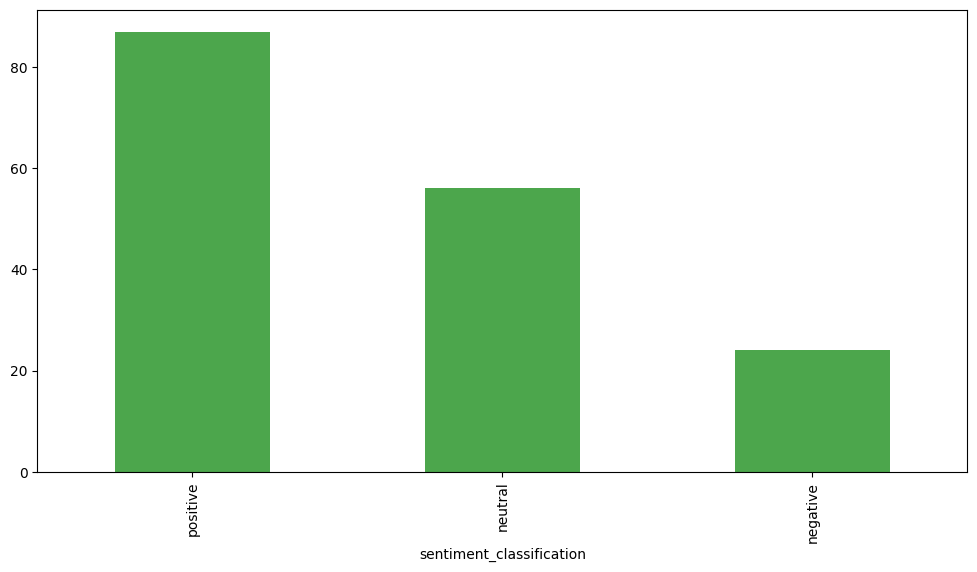

In [40]:
# calculate sentiment scores and assign sentiment labels
sentiment_df = df_sentiment['sentiment_classification'].value_counts().plot(kind='bar', figsize=(12, 6), color = 'g', alpha=0.7)

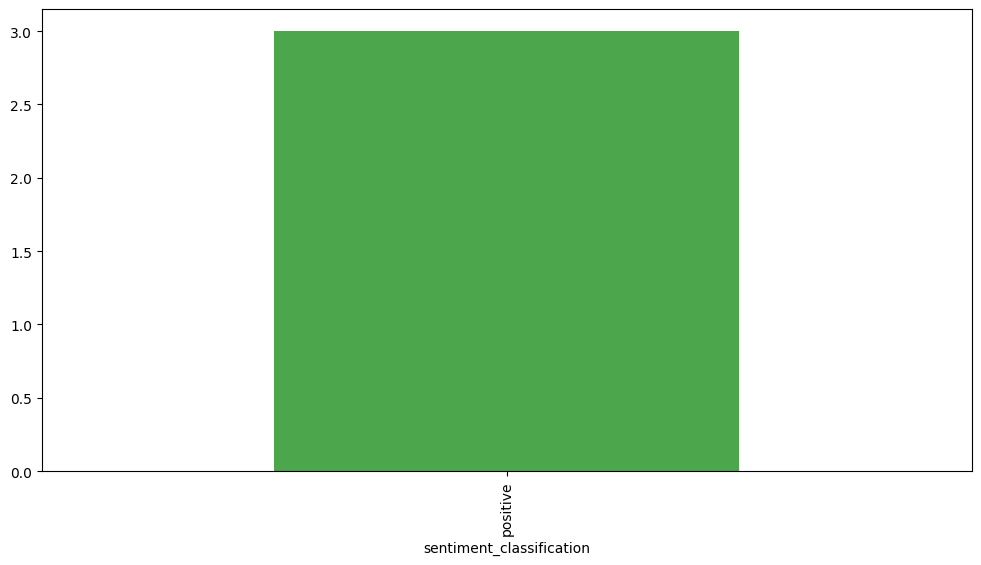

In [41]:
# Score modeling
df_score = df_sentiment[df_sentiment['score'] > 1500]
score_df = df_score['sentiment_classification'].value_counts().plot(kind='bar', figsize=(12, 6), color = 'g', alpha=0.7)